In [1]:
import lettuce as lt
import matplotlib.pyplot as plt

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, HalfwayBounceBackBoundary, FullwayBounceBackBoundary, EquilibriumOutletP, AntiBounceBackOutlet

import torch
import time

In [2]:
### Simulationsparameter - Steuerung 
re = 200    # Reynoldszahl
n_steps = 200000    # Schrittzahl
ny = 200    # Knotenzahl in y Richtung. nx=2*ny
u_init = 1    # initiales Geschwindigkeitsfeld: 1= alle null, 2= parabelförmiger Verlauf über den Kanal-Qerschnitt
perturb_init = True   # leichte Asymmetrie in Anfangs-Geschwindigkeitsverteilung -> Amplitude kann unten gewählt werden
u_in_parabel = True    # Anströmungsprofil: True=parabelförmig, False=homogen
bb_wall = True    # Randbedingungen der lateralen Kanalwände: True= bounce-back-walls, False= periodic
cylinder = True    # Objekt: True = cylinder, False = no obstascle
halfway = True
vtk_out = True    # vtk-Repoter für Animation des Flusses in ParaView: True = vtk-output, False = no vtk-output
#vtk_path = "/mnt/ScratchHDD1/Max_Scratch/cylinder_vtk/out"    # lokal HBRS # Pfad und Name der vtk-output-Dateien
vtk_path = "/home/max/Documents/vtk_output/out"  # lokal Bonn
vtk_interval=50    # vtk_out_intervall: alle wie viel steps soll ein vtk-frame geschrieben werden
drag_out = True    # drag_coefficient als observable-reporter
lift_out = True    # lift_coefficient als observable-reporter

#exmpl: Re1000,steps25000,ny1000 braucht 43min

In [3]:
### EINLASS-Randbedingung
### Modifizierte EquilibrimuBoundaryPU aus boundary.py, welche die Möglichkeit eines parabelförmigen
### Geschwindigkeitsprofils am Einlass erlaubt (ähnlich zu Poiseuille-Flow)

class EquilibriumBoundaryPU:
    """Sets distributions on this boundary to equilibrium with predefined velocity and pressure.
    Note that this behavior is generally not compatible with the Navier-Stokes equations.
    This boundary condition should only be used if no better options are available.
    """

    def __init__(self, mask, lattice, units, velocity, pressure=0):
        self.mask = lattice.convert_to_tensor(mask)
        self.lattice = lattice
        self.units = units
        self.velocity = lattice.convert_to_tensor(velocity)
        self.pressure = lattice.convert_to_tensor(pressure)
        print("die hier definierte ipynb-Version der EqBoundaryPU wurde genutzt :)")

    def __call__(self, f):
        rho = self.units.convert_pressure_pu_to_density_lu(self.pressure)
        
        ### räumliche Form des einströmenden Geschwindigkeitsprofils
        ### PARABEL (später mal Poiseuille) oder HOMOGEN
### Geschwindigkeitsverteilung am Einlass        
        if u_in_parabel:
            ## Parabelförmige Geschwindigkeit, vom zweiten bis vorletzten Randpunkt (keine Interferenz mit lateralen Wänden (BBB  oder periodic))
                ## How to Parabel:
                ## 1.Parabel in Nullstellenform: y = (x-x1)*(x-x2)
                ## 2.nach oben geöffnete Parabel mit Nullstelle bei x1=0 und x2=x0: y=-x*(x-x0)
                ## 3.skaliere Parabel, sodass der Scheitelpunkt immer bei ys=1.0 ist: y=-x*(x-x0)*(1/(x0/2)²)
                ## (4. optinal) skaliere Amplitude der Parabel mit 1.5, um dem Integral einer homogenen Einstromgeschwindigkeit zu entsprechen
            ny = f.shape[2]  # Gitterpunktzahl in y-Richtung
            u1 = np.zeros((1,ny))  # x-Geschwindigkeiten der Randbedingung
#            parabel_breite = ny-2  # lässt die laterale Wand-Randbedingung aus, diese wird nicht belegt                
#            y_werte = np.arange(0, ny) + 0.5  # die 0.5 shiftet die Parabel, sodass man Achsensymmetrie erhält, sowohl bei geraden, als auch ungeraden Gitterpunktzahlen
            y_werte = np.linspace(0,ny,ny)  # linspace() erzeugt n Punkte zwischen 0 und ny inklusive 0 und ny, so wird die Parabel auch symmetrisch und ist trotzdem an den Rändern NULL
            u1[:,1:-1] = - self.units.characteristic_velocity_lu * y_werte[1:-1] * (y_werte[1:-1] - ny) * 1/(ny/2)**2 
                # (!) es muss die charakteristische Geschwindigkeit in LU genutzt werden (!) -> der Unterschied PU/LU ist u.U. Größenordnungen und es kommt bei falscher Nutzung zu Schock/Überschall und somit Sim-Crash
                # Skalierungsfaktor 3/2=1.5 für die Parabelamplitude, falls man im Integral der Konstantgeschwindigkeit entsprechenn möchte.
                # in 2D braucht u1 dann die Dimension 1 x ny (!)
            # u1: ux-Werte, u2: uy-Werte, beide stehen nebeneinander in u
            u2 = np.zeros_like(u1)  # y-Geschwindigkeit = 0
            # verpacke u-Feld
            u = np.stack([u1, u2], axis=0)
            u = self.lattice.convert_to_tensor(u)
            # Berechne Gleichgewichtsverteilung für vorgegebene Geschwindigkeitswerte
            feq = self.lattice.equilibrium(rho, u) # Berechne Gleichgewichtsverteilung auf Einlassrand
            f[:,0,:]=feq[:, 0, :]  # setze die FEQ mit parabelförmiger Geschwindigkeit nur auf den Einlass Rand
                # besser irgendwie so: f = torch.where(self.mask, feq, f), aber dafür müsste feq die gleiche Dimension haben, wie das komplette f und nicht nur eine Spalte abbilden
                # dazu brauche ich noch ein einsum...wie unten
        else:
            ## konstante Geschwindigkeitswert (u_LU: 0.0289, u_PU: 1.0)        
            u = self.units.convert_velocity_to_lu(self.velocity) # ein Tensor: tensor([0.0289, 0.0000], device='cuda:0')
            feq = self.lattice.equilibrium(rho, u)  # berechne komplette Gleichgewichtsverteilung
            print("feq für konstante Geschwindigkeit am Einlass:", feq)
            feq = self.lattice.einsum("q,q->q", [feq, torch.ones_like(f)])  # feq wird "breit" gezogen auf die Größe/Dimensionen von f
            f = torch.where(self.mask, feq, f) # überschreibe f am Einlass durch neue feq
        
        return f

In [4]:
### flow/Cylinder2D: modifizierte flows/obstacle.py Klasse, zur Simulation eines umströmten Zylinders im 2D-Kanal
# nicht zu verwechseln mit flows/cylinder2D.py im development- und dragAndForce-branch

class Cylinder2D:

    def __init__(self, shape, reynolds_number, mach_number, lattice, domain_length_x, 
                 char_length=1, char_velocity=1):
        # übernehme Objektreferenzen, berechne char_length_lu, übernehme Kennzahlen (Re, Ma, l_char, u_char)
        if len(shape) != lattice.D:
            raise ValueError(f"{lattice.D}-dimensional lattice requires {lattice.D}-dimensional `shape`")
        self.shape = shape
        char_length_lu = shape[0] / domain_length_x * char_length
        self.units = UnitConversion(
            lattice,
            reynolds_number=reynolds_number,
            mach_number=mach_number,
            characteristic_length_lu=char_length_lu,
            characteristic_length_pu=char_length,
            characteristic_velocity_pu=char_velocity
        )
        # lege bool-Maske der korrekten Dimensionen an, welche alle Nicht-Fluid-Knoten markiert 
        # ...und als Prototyp für BounceBackBoundary-Masken (Wände, Obstacle) dient
        self._mask = np.zeros(shape=self.shape, dtype=bool) #deprecation warning: "np.bool" 
            # ...ist ein alter alias für das buildin "bool"
            
    @property
    def mask(self):
        return self._mask

    @mask.setter
    def mask(self, m):
        # Maskenbelegung wird auf korrekten Datentyp und Dimension getestet
        assert isinstance(m, np.ndarray) and m.shape == self.shape
        self._mask = m.astype(bool) #deprecation warning: "np.bool" ist ein alter alias für das buildin "bool"

    ### DEFINIERE ANFANGSBEDINGUNG
    def initial_solution(self, x):
        p = np.zeros_like(x[0], dtype=float)[None, ...]
        u_char = self.units.characteristic_velocity_pu * self._unit_vector()
        u_char = append_axes(u_char, self.units.lattice.D) # u_char ist in PU (!) -> 1.0
        u = (1 - self.mask) * u_char # alles was nicht obstacle ist, wird 1 gesetzt
        
### Wähle initiale Geschwindigkeitsverteilung:
        #u_init = 0 
            # 0: uniform u=0
            # 1: uniform parabolic (similar to poiseuille-flow)
        if u_init == 1: # no velocity
            ### initiale velocity u=0
            u = u * 0
        elif u_init ==2: # uniform parabolic (similar to poiseuille-flow)
            ### initiale Geschwindigkeitsverteilung parabelförmig (0 auf lateralen Wänden, dazwischen Parabel)
            ny = self.shape[1]  # Gitterpunktzahl in y-Richtung           
            u1=np.zeros(ny)  # Vektor für erste Spalte (u(x=0)) des u-Feldes
            # Geschwindigkeitsparabel mit Amplitude u_char
            y_werte = np.linspace(0,ny,ny)  # linspace() erzeugt n Punkte zwischen 0 und ny inklusive 0 und ny, so wird die Parabel auch symmetrisch und ist trotzdem an den Rändern NULL
            u1[:,1:-1] = - self.units.characteristic_velocity_lu * y_werte[1:-1] * (y_werte[1:-1] - ny) * 1/(ny/2)**2 
            #print("u1-Parabel aus initial_solution: ", u1)
            u=np.einsum('k,ijk->ijk',u1,u) # multipliziere jede Geschwindigkeits-Spalte mit der Parabel
            #print("u-Feldaus initial_solution: ", u)

### Störe Initialverteilung für Asymmetrie und Ausbildung einer Karman'schen Wirbelstraße
        #perturb_init = True
        if perturb_init:
            # überlagere Sinus-Störung in ux über die zweite Spalte u(x=1)
            ny = x[1].shape[1]
            if u.max() < 0.5*self.units.characteristic_velocity_pu:
                # Addition der Parabel, falls das initiale Geschwindigkeitsfeld sehr kleine Werte hat (z.B. null ist)
                u[0][1] += np.sin(np.arange(0, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_pu * 1.0 #0.3
            else:
                # sonst Multiplikation mit der Parabel
                u[0][1] *= 1 + np.sin(np.arange(0, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_pu * 0.3
            # kontrolliere gestörtes u(x=1,y=:) durch plotting:
            #print("perturbed inlet-velocity:")
            #plt.plot(u[0][1])
            #plt.show()
        return p, u

    @property
    def grid(self):
        # erstelle MESHGRID: Koordinatenverteilung (Positionen) über das nx x xy Raster und gibt je ein x- und ein y-2D-Array zurück
            # linspace erlaubt endpoint=True im Gegensatz zu Arange "np.linspace(0,n,n)" war vorher "np.arange(n)"
            # d.h. von 0 bis n enthält auch 0 und n als Anfangs und Endpunkte und nicht n-1
        xyz = tuple(self.units.convert_length_to_pu(np.linspace(0,n,n)) for n in self.shape)  # Tupel aus Listen der x-Wert, y-Werte, (und z-Werte)
        return np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Werten

    @property
    def boundaries(self):
        # definiere Boundaries:
        # inlet ("left side", x[0],y[1:-1])
        in_mask = np.zeros(self.grid[0].shape, dtype=bool)  # dimensioniere in_mask
        in_mask[0, 1:-1] = True  # Einlass: erste Spalte, ohne laterale Wände
        inlet_boundary = EquilibriumBoundaryPU(
                                    in_mask,
                                    flow.units.lattice, flow.units,
                                    flow.units.characteristic_velocity_pu * flow._unit_vector())
        # lateral walls ("top and bottom walls", x[:], y[0,-1])
        lateral_boundary = None
        if bb_wall == True:
            wall_mask = np.zeros_like(flow.mask)
            wall_mask[:, [0, -1]] = True  # laterale Wände markieren (ohne letzte Spalte, da dort "outlet_boundary" definiert ist)
            flow.mask[np.where(wall_mask)] = 1  # übernehme Wände in BBB-Maske
            if halfway == True:  # use halfway bounce back
                lateral_boundary = HalfwayBounceBackBoundary(wall_mask,self.units.lattice)
                print("lateral halfway")
            else:  # else use fullway bounce back
                lateral_boundary = FullwayBounceBackBoundary(wall_mask,self.units.lattice)
                print("lateral fullway")
        # oulet ("right side", x[-1],y[:])
        outlet_boundary = EquilibriumOutletP(self.units.lattice, [1,0])  # Auslass in positive x-Richtung
        # obstacle (obstacle "cylinder" with radius centered at position x_pos, y_pos)
        obstacle_mask = np.zeros_like(flow.mask)
        obstacle_boundary = None
        if cylinder == True:
            radius = 0.5  # radius of cylinder obstacle in PU
            x_pos = 2.5  # x_pos of center of cylinder in PU
            y_pos = 2.5  # y_pos of center of cylinder in PU
            
            x, y = self.grid #gibt ein Meshgrid zurück: x-2D-Array, y-2D-Array
                # in der ursprünglichen Implementierung von grid mit "arange(n)" reicht das grid für n=10 z.B. von 0 bis 9... d.h. die Position 5 ist nicht in der Mitte (!)
                # in Cylnider2D (s.o.) ist das grid mit linspace erstellt und geht für n Punkte von 0 bis n inklusive 0 und n als Randpunkte
            
            # Zylinder - Kreisgleichung (x-x0)²+(y-y0)²<r² in PU
            condition = np.sqrt((x-x_pos)**2+(y-y_pos)**2) < radius #die Kreisgleichung rechnet in PU, d.h. die Auflösung spielt hier keine Rolle(!)
            # area=2*radius  # die angeströmte Querschnittsfläche (zur Berechnung des drag coefficient): A=2*r in 2D, ! area is in PU
            flow.mask[np.where(condition)] = 1  # übernehme Obstacle Form (mask als Bool) in BBB-Maske
            obstacle_mask[np.where(condition)] = 1  # definiere Obstacle Form (ohne andere Wände), für Kraftberechnung
            if halfway == True:
                obstacle_boundary = HalfwayBounceBackBoundary(obstacle_mask, self.units.lattice)
                print("obstacle halfway")
            else:
                obstacle_boundary = FullwayBounceBackBoundary(obstacle_mask, self.units.lattice)
                print("obstacle fullway")
        
        return [
            inlet_boundary, 
            outlet_boundary, 
            lateral_boundary, 
            obstacle_boundary
        ]

    # i-te Zeile der Einheitsmatrix der Dimension D; im default ist nur der erste Eintrag mit einer 1 belegt
    def _unit_vector(self, i=0):
        return np.eye(self.units.lattice.D)[i]

In [5]:
### Simulationssetup

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
    # stencil, device, dtype

# flow: definiere Boxgröße, Boxdiskretisierung, Flussgeschwindigkeit, Flussviskosität
flow = Cylinder2D(
    (2*ny, ny), #shape der 2D-Box ist XxY: 2ny x ny
    reynolds_number=re, #50.0
    mach_number=0.05,
    lattice=lattice,
    domain_length_x=10.0, #10.1, # in PU
)
    # im flow werden alle Boundaries und das Obstacle definiert (s.o.)

### Simulations-Objekt (Simulator)
tau = flow.units.relaxation_parameter_lu
sim = lt.Simulation(flow, lattice, lt.BGKCollision(lattice, tau), 
                    lt.StandardStreaming(lattice))
    # Flow, Lattice-Parameter, KollisionsOperator-Objekt(Parameter), Streaming-Objekt

### Reporter

# VTK Reporter -> Visualisierung
if vtk_out == True:
    VTKreport = lt.VTKReporter(lattice, flow, interval=vtk_interval, filename_base=vtk_path)
    sim.reporters.append(VTKreport)

# Observable reporter: drag coefficient
if drag_out == True:
    DragObservable = lt.DragCoefficient(lattice,flow,sim,area=1)  # erstelle Observable // ! area A=2*r is in PU
    Dragreport = lt.ObservableReporter(DragObservable, out=None)  # erstelle Reporter für Observable
    sim.reporters.append(Dragreport)  # hänge Reporter in Simulator ein
    
# Observable reporter: lift coefficient
if lift_out == True:
    LiftObservable = lt.LiftCoefficient(lattice,flow,sim,area=1)
    Liftreport = lt.ObservableReporter(LiftObservable, out=None)
    sim.reporters.append(Liftreport)

initializing simulation
die hier definierte ipynb-Version der EqBoundaryPU wurde genutzt :)
lateral halfway
obstacle halfway


In [6]:
### Einfache Simulation

t_start=time.time()

mlups = sim.step(n_steps) #Simulation mit Schrittzahl n_steps

print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("Re=",re)
print("char_velocity_LU", flow.units.characteristic_velocity_lu)
print("number of steps:",n_steps)
print("runtime: ",time.time()-t_start, "seconds")

finishes simulation
MLUPS: 29.95024605120661
PU-Time:  144.33756729740648  seconds
Re= 200
char_velocity_LU 0.028867513459481294
number of steps: 200000
runtime:  534.2195749282837 seconds


In [ ]:
### Simulation mit u_diff

### Kontrolliere Asymmetrie der Simulation über Vergleich der Geschwindigkeit über die Symmetrieachse
diff_list = []  # Listet pro Schritt delta u eines definierten Messpunktes
u_list = []  # Liste pro Schritt u eines definierten Messpunktes

# Wähle Koordinaten des Geschwindigkeits-Messpunkts für die u_diff Analyse (relativ zum Gitter in LU)
nx, ny = flow.shape
x_test = int(nx/2)
y_test = int(ny/4)

t_start = time.time()
for i in range(n_steps):
    sim.step(1)
    #finde Asymmetrie der Geschwindigkeit in y-Richtung um Spiegelachse:
    #Differenz zwischen ux und ux an Symmetrieachse gespiegelt:
    u = lattice.u(sim.f)
    u_diff = torch.flip(u,[2])-u
    u_list.append(u[0,x_test,y_test].cpu())
    diff_list.append(u_diff[0,x_test,y_test].cpu())
t_end = time.time()-t_start
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",time.time()-t_start, "seconds")

In [ ]:
### plot u_diff - Symmetrieuntersuchung der Geschwindigkeit

fig, axs = plt.subplots(1, 2, figsize=(10, 2.7), layout='constrained')
axs[0].plot(u_list)
axs[0].set_title("u @ x,y = "+str(x_test)+","+str(y_test))
axs[1].plot(diff_list)
axs[1].set_title("u_diff @ x,y = "+str(x_test)+","+str(y_test))

In [ ]:
### print Sim paramerters

print("### sim parms ###")
print("Re = ", re)
print("n_steps = ", n_steps)
print("nx x ny = ", 2*ny, " x ", ny)
print("u_init = ", u_init)
print("u_in_parabel = ", u_in_parabel)
print("bb_wall = ", bb_wall)
print("cylinder = ", cylinder)
print("vtk_out = ", vtk_out)

  stepLU         timePU         Cd
[[0.00000000e+00 0.00000000e+00 6.66133815e-16]
 [1.00000000e+00 7.21687836e-04 6.66133494e-16]
 [2.00000000e+00 1.44337567e-03 6.66133398e-16]
 ...
 [1.99998000e+05 1.44336124e+02 3.40953847e-02]
 [1.99999000e+05 1.44336846e+02 3.40932614e-02]
 [2.00000000e+05 1.44337567e+02 3.40911365e-02]]


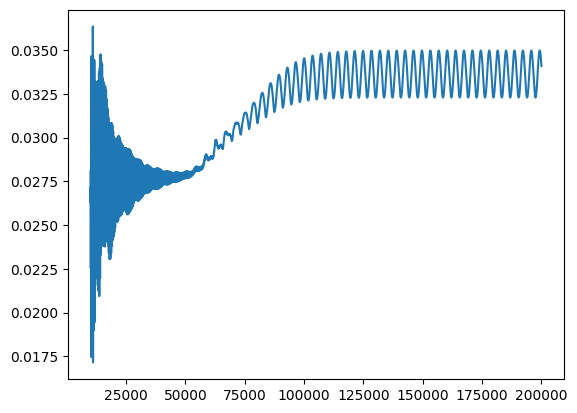

In [7]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
print('  stepLU        ', 'timePU        ', 'Cd')
print(drag_coefficient) # prints: stepLU, timePU, value
plt.figure
plt.plot(drag_coefficient[10000:,0],drag_coefficient[10000:,2])

  stepLU         timePU         Cl
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  7.21687836e-04  0.00000000e+00]
 [ 2.00000000e+00  1.44337567e-03  0.00000000e+00]
 ...
 [ 1.99998000e+05  1.44336124e+02 -1.04813130e-02]
 [ 1.99999000e+05  1.44336846e+02 -1.04708463e-02]
 [ 2.00000000e+05  1.44337567e+02 -1.04603717e-02]]


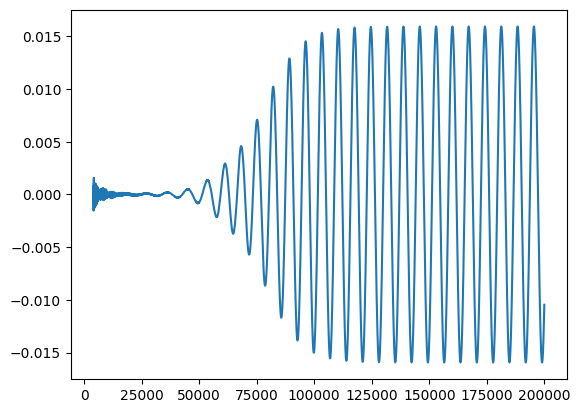

In [8]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
print('  stepLU        ', 'timePU        ', 'Cl')
print(lift_coefficient) # prints: stepLU, timePU, value
plt.figure
plt.plot(lift_coefficient[4000:,0],lift_coefficient[4000:,2])

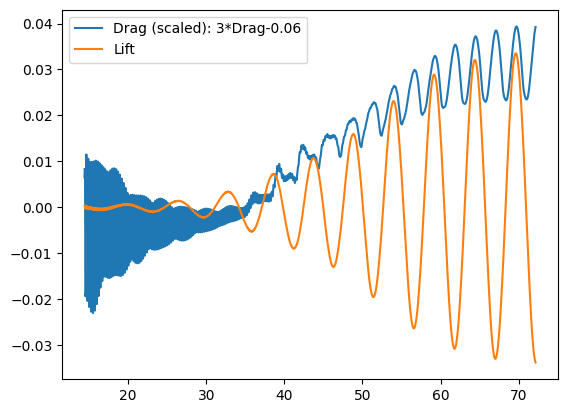

In [53]:
### plot Drag coefficient AND Lift Coefficient

drag_coefficient = np.array(Dragreport.out)
plt.figure
plt.plot(drag_coefficient[10000:,1],3*(drag_coefficient[10000:,2]-0.06))
lift_coefficient = np.array(Liftreport.out)
plt.plot(lift_coefficient[10000:,1],lift_coefficient[10000:,2])
plt.legend(labels=["Drag (scaled): 3*Drag-0.06", "Lift"])

In [ ]:
### EIN STEP
sim.step(1)